<a href="https://colab.research.google.com/github/tomasvicar/cell_profile_analysis/blob/master/cell_profile_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install read-roi
!pip install scikit-fmm

In [ ]:
# připojení ke google disku - je nutné potvrdit
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from read_roi import read_roi_zip
from skimage.io import imread
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skfmm
from scipy.ndimage.morphology import distance_transform_edt
import pandas as pd
from pathlib import Path
import os

In [ ]:
# nastavení složky s daty - je možné snadno skopírovat cestu pro rozkliknutí menu na levém panelu
# data jsou čekávány ve formě složek pro jednotlivé obrázky; složka obsahu zip RoiSet.zip z Fiji
data_path = "/content/drive/MyDrive/cell_profile_analysis/data/2"
number_of_sectors = 3

In [ ]:
fnames_roi = glob.glob(data_path + '/**/*.zip')
print("found ROIs:" + str(fnames_roi))

found ROIs:['/content/drive/MyDrive/cell_profile_analysis/data/2/63x_B3_F-actin+TAG_1_4.zip', '/content/drive/MyDrive/cell_profile_analysis/data/2/63x_B3_F-actin+TAG_1_5.zip']


In [ ]:
def get_cells_and_nucleus_pairs(roi_masks):

  cells = []
  nuclei = []
  for roi_mask_tested_num, roi_mask_tested in enumerate(roi_masks):
    find = False
    for roi_mask_to_compare_num, roi_mask_to_compare in enumerate(roi_masks):
      if roi_mask_tested_num == roi_mask_to_compare_num:
        continue
      overlap = np.sum(roi_mask_tested & roi_mask_to_compare)
      my_size = np.sum(roi_mask_tested)
      his_size = np.sum(roi_mask_to_compare)

      if np.abs(overlap - my_size) < 0.1 * my_size:
        nuclei.append(roi_mask_tested)
        find = True
        break

    if not find:
      cells.append(roi_mask_tested)

  pairs = []
  for cell in cells:
    all_nuclei_in_cell = np.zeros_like(cell)
    for nucleus in nuclei:

      overlap = np.sum(cell & nucleus)
      nucleus_size = np.sum(nucleus)

      if np.abs(overlap - nucleus_size) < 0.1 * nucleus_size:
        all_nuclei_in_cell[nucleus] = True


    pairs.append((cell, all_nuclei_in_cell))


  return pairs


def rois2masks(rois, img_shape):
  roi_masks = []
  for roi_name, roi in rois.items():
    roi_mask = np.zeros(img_shape)
    points = np.array([roi['x'], roi['y']]).T
    cv2.fillPoly(roi_mask, [points], color=1)

    roi_masks.append(roi_mask > 0)
  return roi_masks



def bwdistgeodesic(seeds, mask, bakround_value=np.Inf, seed2zero=True, diminsion_weights = None):

    m = np.ones_like(seeds,dtype=np.float32)
    m[seeds > 0] = -1;


    m = np.ma.masked_array(m, mask==0)

    if diminsion_weights:
        distance = skfmm.distance(m,dx=1/np.array(diminsion_weights))
    else:
        distance = skfmm.distance(m)

    distance = np.array(distance.data)

    if seed2zero:
        distance[distance < 0] = 0

    distance[mask == 0] = bakround_value

    return distance


def bwdist(seeds,  bakround_value=np.Inf, seed2zero=True, diminsion_weights = None):

    m = np.ones_like(seeds,dtype=np.float32)
    m[seeds > 0] = -1;



    if diminsion_weights:
        distance = skfmm.distance(m,dx=1/np.array(diminsion_weights))
    else:
        distance = skfmm.distance(m)

    distance = np.array(distance.data)

    if seed2zero:
        distance[distance < 0] = 0


    return distance


def visboundaries(img,color='r',linewidth=2):


    img=(img>0).astype(np.uint8)*255


    contours,_= cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:

        tmp1=np.concatenate((cnt[:,0,0],cnt[[0],0,0]))
        tmp2=np.concatenate((cnt[:,0,1],cnt[[0],0,1]))

        plt.plot(tmp1,tmp2,color=color,linewidth=linewidth)





<ipython-input-55-e74c6a5b9148>:25: RuntimeWarning: invalid value encountered in true_divide
  nuc_dist_normalized = nuc_dist / (nuc_dist + bg_dist)
<ipython-input-55-e74c6a5b9148>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result_cell, ignore_index=True)


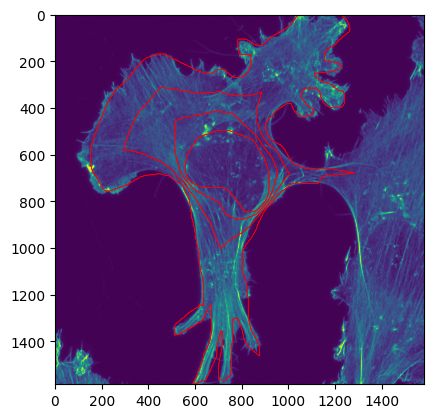

<ipython-input-55-e74c6a5b9148>:25: RuntimeWarning: invalid value encountered in true_divide
  nuc_dist_normalized = nuc_dist / (nuc_dist + bg_dist)
<ipython-input-55-e74c6a5b9148>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result_cell, ignore_index=True)


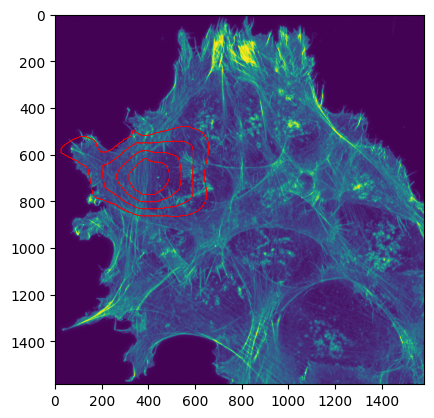

<ipython-input-55-e74c6a5b9148>:25: RuntimeWarning: invalid value encountered in true_divide
  nuc_dist_normalized = nuc_dist / (nuc_dist + bg_dist)
<ipython-input-55-e74c6a5b9148>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result_cell, ignore_index=True)


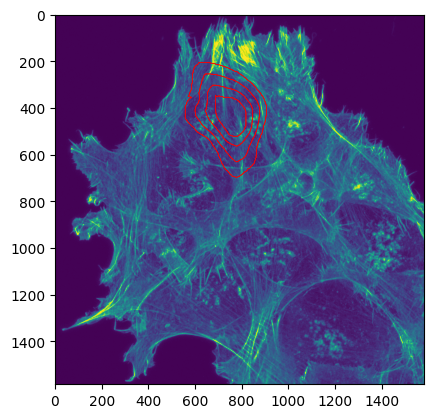

<ipython-input-55-e74c6a5b9148>:25: RuntimeWarning: invalid value encountered in true_divide
  nuc_dist_normalized = nuc_dist / (nuc_dist + bg_dist)
<ipython-input-55-e74c6a5b9148>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result_cell, ignore_index=True)


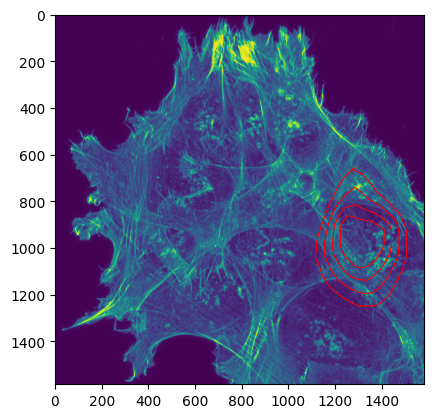

<ipython-input-55-e74c6a5b9148>:25: RuntimeWarning: invalid value encountered in true_divide
  nuc_dist_normalized = nuc_dist / (nuc_dist + bg_dist)
<ipython-input-55-e74c6a5b9148>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result_cell, ignore_index=True)


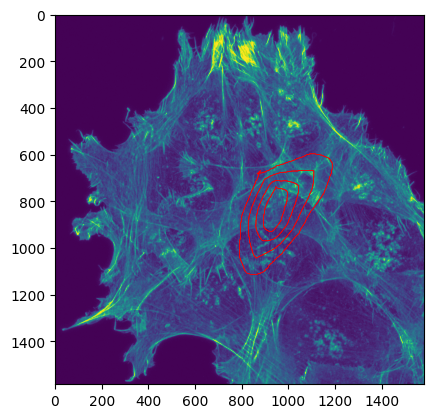

<ipython-input-55-e74c6a5b9148>:25: RuntimeWarning: invalid value encountered in true_divide
  nuc_dist_normalized = nuc_dist / (nuc_dist + bg_dist)
<ipython-input-55-e74c6a5b9148>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result_cell, ignore_index=True)


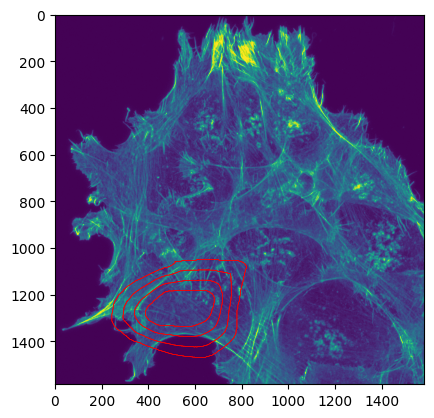

,file,cell_number,nuc_dist_sector_1_channel_1,nuc_dist_sector_2_channel_1,nuc_dist_sector_3_channel_1,nucleus_channel_1,cytoplasm_channel_1,nuc_dist_sector_1_channel_2,nuc_dist_sector_2_channel_2,nuc_dist_sector_3_channel_2,nucleus_channel_2,cytoplasm_channel_2
0,/content/drive/MyDrive/cell_profile_analysis/d...,1,60.0,64.0,50.0,34.0,53.0,50.0,53.0,57.0,31.0,52.0
1,/content/drive/MyDrive/cell_profile_analysis/d...,1,71.0,71.0,61.0,70.0,68.0,45.0,57.0,55.0,49.0,53.0
2,/content/drive/MyDrive/cell_profile_analysis/d...,2,2.0,2.0,2.0,2.0,2.0,54.0,56.0,57.0,51.0,55.0
3,/content/drive/MyDrive/cell_profile_analysis/d...,3,4.0,11.0,11.0,3.0,5.0,61.0,62.0,57.0,53.0,58.0
4,/content/drive/MyDrive/cell_profile_analysis/d...,4,27.0,24.0,25.0,33.0,25.0,62.0,58.0,64.0,70.0,63.0
5,/content/drive/MyDrive/cell_profile_analysis/d...,5,2.0,2.0,2.0,2.0,2.0,52.0,56.0,52.0,46.0,51.0


In [ ]:
results = pd.DataFrame()
Path(data_path + '/results').mkdir(parents=True, exist_ok=True)

for fname_roi in fnames_roi:

  fname_img = fname_roi.replace('.zip', '.tif')
  img = imread(fname_img).astype(np.float32)
  img_projection = np.max(img, axis=0)
  rois = read_roi_zip(fname_roi)

  roi_masks = rois2masks(rois, img.shape[-2:])


  cell_nucleus_pairs = get_cells_and_nucleus_pairs(roi_masks)

  for cellnum, (cell, nucleus) in enumerate(cell_nucleus_pairs):
    result_cell = dict()
    result_cell['file'] = fname_roi
    result_cell['cell_number'] = cellnum + 1

    nuc_dist = bwdistgeodesic(nucleus, cell)
    bg_dist = bwdist(cell == 0)


    nuc_dist_normalized = nuc_dist / (nuc_dist + bg_dist)
    nuc_dist_normalized[cell == 0] = np.Inf
    nuc_dist_normalized[nucleus == 1] = np.Inf

    # plt.imshow(nuc_dist_normalized)

    for color_channel_num in range(img_projection.shape[0]):
      color_channel = img_projection[color_channel_num, ...]
      nuc_dist_normalized_tmp = nuc_dist_normalized.copy()

      plt.imshow(color_channel)

      for sector_num in range(number_of_sectors + 2):



        if sector_num < number_of_sectors:
          # p = np.percentile(nuc_dist_normalized[nuc_dist_normalized < np.Inf], (100 / number_of_sectors) * (sector_num + 1) )
          # sector = nuc_dist_normalized < p
          p = (1 / number_of_sectors) * (sector_num + 1)
          sector = nuc_dist_normalized_tmp < p
        elif sector_num == number_of_sectors:
          sector = nucleus
        elif sector_num == (number_of_sectors + 1):
          sector = cell

        nuc_dist_normalized_tmp[sector] = np.Inf

        visboundaries(sector,linewidth=0.3)



        res = np.median(color_channel[sector])

        if sector_num < number_of_sectors:
          result_cell['nuc_dist_sector_' + str(sector_num + 1) + '_channel_' +  str(color_channel_num + 1)] = res
        elif sector_num == number_of_sectors:
          result_cell['nucleus_channel_' +  str(color_channel_num + 1)] = res
        elif sector_num == (number_of_sectors + 1):
          result_cell['cytoplasm_channel_' +  str(color_channel_num + 1)] = res



    results = results.append(result_cell, ignore_index=True)

    example_img_fname = data_path + '/results/' + fname_roi.replace(data_path, '') + '_' + str(cellnum + 1) + '.png'
    Path(os.path.split(example_img_fname)[0]).mkdir(parents=True, exist_ok=True)
    plt.savefig(example_img_fname)
    plt.show()


results.to_excel(data_path + '/results/results_table.xlsx')
results











